## **EMOTION RECOGNITION USING LSTM**

1. Overview : Explore text-based emotion recognition, a dynamic field in NLP, focusing on deciphering diverse emotional states in textual content.

2. Objective : Build a system for automatic categorization of text into six emotions ( joy , sadness , fear , anger , love , surprise)

3. Model Choice : Utilize LSTM (Long Short-Term Memory) networks, a type of RNN.

4. Implementation : Implemented with TensorFlow.

# **Importing all the required modules and libraries.**

1. The Dataset:
This is a kaggle data set by the name "Emotion Dataset for emotion recognition tasks".
2. BRIEF DESCIPTION : A dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise.
3. Any data involving sentiment analysis is a Binary Classification Problem. In this dataset, we have 6 different classes , so we will be treating the above problem as a multi-class classification Problem.

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
from google.colab import files
uploaded = files.upload()

Saving TEST.csv to TEST.csv
Saving TRAINING.csv to TRAINING.csv
Saving VALIDATION.csv to VALIDATION.csv


In [3]:
val_data = pd.read_csv('/content/VALIDATION.csv')
train_data = pd.read_csv('/content/TRAINING.csv')
test_data = pd.read_csv('/content/TEST.csv')

In [4]:
print("Validation data :",val_data.shape)
print("Train data :",train_data.shape)
print("Test data :",test_data.shape)

Validation data : (2000, 2)
Train data : (16000, 2)
Test data : (2000, 2)


There was a lot of data in the Testing file so I transferred some of it to the Validation Set.

In [5]:
half_test_data = test_data.iloc[1000:]
test_data = test_data.iloc[:1000]

val_data = pd.concat([val_data, half_test_data], axis=0)

print("new Vald data :",val_data.shape)
print("new Test data :",test_data.shape)

new Vald data : (3000, 2)
new Test data : (1000, 2)


In [6]:
train_data.head(10)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


Adding Labels to the Data.

In [7]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train_data['label_name'] = train_data['label'].map(labels_dict)
train_data.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [8]:
train_data.groupby(["label_name","label"]).size()

,,0
label_name,label,
anger,3,2159
fear,4,1937
joy,1,5362
love,2,1304
sadness,0,4666
surprise,5,572


<Axes: xlabel='label_name'>

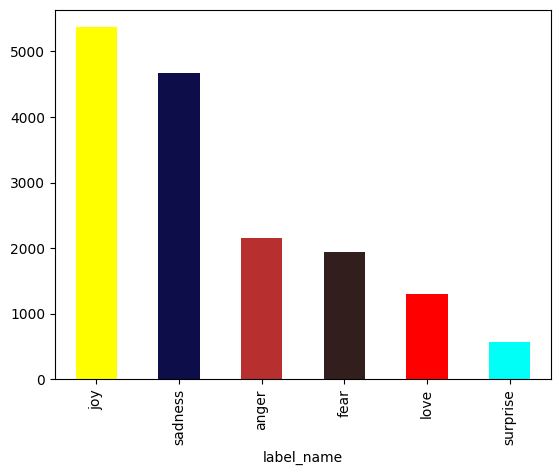

In [9]:
train_data["label_name"].value_counts().plot(kind='bar',color=['yellow', '#0c0d49', '#b82f2f', '#331e1e', 'red','#00fff7'])

# **DATA CLEANING**

As it is a Kaggle Dataset the Data is already pre-processed But we will still check for NULL values

In [10]:
print(train_data.isnull().sum())
print(val_data.isnull().sum())
print(test_data.isnull().sum())

text          0
label         0
label_name    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


# **Tokenization and Stemming**

> Tokenization assigns unique IDs to words, creating a word index or vocabulary.

> Example : Sentence : "Tokenization is essential for NLP tasks." Tokenized Output : ['Tokenization', 'is', 'essential', 'for', 'NLP', 'tasks', '.']

> Stemming is a technique used to reduce an inflected word down to its word stem.

> Example : Original Words : running , programming , swimming , happiness , programmer (5 words) Stemmed Words : run , program , swim , happi (4 words)

In [11]:
all_list = train_data['text'].tolist() + test_data['text'].tolist() + val_data['text'].tolist()

In [12]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(all_list)
word_index1 = tokenizer1.word_index

print("Number of words without Stemming:",len(word_index1))

stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in word_index1.keys()]

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(stemmed_words)
word_index2 = tokenizer2.word_index

print("Number of words with Stemming:",len(word_index2))

Number of words without Stemming: 17096
Number of words with Stemming: 11705


In [13]:
def preprocess_data(data):
    new_data = []
    for index, row in data.iterrows():
        test_split = row['text'].split()
        stemmed_words2 = [stemmer.stem(word) for word in test_split]
        token_list= tokenizer2.texts_to_sequences([stemmed_words2])[0]
        new_data.append([token_list,row['label']])
    return new_data

In [14]:
train_data.groupby(["label_name","label"]).size()

,,0
label_name,label,
anger,3,2159
fear,4,1937
joy,1,5362
love,2,1304
sadness,0,4666
surprise,5,572


In [15]:
new_train_data = preprocess_data(train_data)
print(train_data['text'][0])
print(new_train_data[0])

i didnt feel humiliated
[[3198, 3265, 220, 665], 0]


In [16]:
new_val_data = preprocess_data(val_data)
print(val_data['text'][0])
print(new_val_data[0])

im feeling quite sad and sorry for myself but ill snap out of it soon
[[3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380], 0]


In [17]:
# Splitting into train_X and train_y
train_X = [row[0] for row in new_train_data]
train_y = [row[1] for row in new_train_data]

# Print the results
print("train_X:", train_X[0])
print("train_y:", train_y[0])

train_X: [3198, 3265, 220, 665]
train_y: 0


In [18]:
val_X = [row[0] for row in new_val_data]
val_y = [row[1] for row in new_val_data]

print("train_X:", val_X[0])
print("train_y:", val_y[0])

train_X: [3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380]
train_y: 0


Add Padding.

In [19]:
length_of_longest_sentence = len(max(train_X, key=len))
print(length_of_longest_sentence)
print(max(train_X, key=len))

66
[3198, 613, 3250, 3588, 3217, 3204, 3198, 927, 3245, 1497, 3245, 1354, 3217, 3245, 1303, 1296, 3200, 2107, 1284, 1276, 3220, 220, 3598, 3213, 220, 1276, 3528, 3217, 7890, 4263, 3221, 5569, 1552, 3243, 3198, 4263, 3221, 1552, 5570, 5570, 3198, 3579, 5569, 3198, 7891, 1276, 3200, 3202, 1293, 3219, 1401, 3948, 3598, 3213, 3223, 239, 3528, 3213, 85, 3267, 579, 1658, 3206, 3201, 239, 1289]


In [20]:
for i in range(len(train_X)):
    for j in range(length_of_longest_sentence-len(train_X[i])):
        train_X[i].append(0)

for i in range(len(val_X)):
    for j in range(length_of_longest_sentence-len(val_X[i])):
        val_X[i].append(0)

In [22]:
train_X = np.array(train_X)
train_y = np.array(train_y)
val_X = np.array(val_X)
val_y = np.array(val_y)

print(train_X.shape,train_y.shape)
print(val_X.shape,val_y.shape)

(16000, 66) (16000,)
(3000, 66) (3000,)


One-Hot Encoding

In [23]:
# Convert labels to one-hot encoding
train_y_one_hot = to_categorical(train_y, num_classes=16000)
val_y_one_hot = to_categorical(val_y, num_classes=16000)

# **Create the Model**

Bi-LSTM Neural Network Training

In [25]:
model = Sequential()
model.add(Embedding(16000, 100, input_length=66))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(16000, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(train_X, train_y_one_hot, epochs=25, verbose=1,validation_data=(val_X,val_y_one_hot))
#print model.summary()
print(model)

Epoch 1/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 179s 349ms/step - accuracy: 0.3028 - loss: 1.9887 - val_accuracy: 0.3540 - val_loss: 1.6796
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 182s 364ms/step - accuracy: 0.2934 - loss: 1.7230 - val_accuracy: 0.3550 - val_loss: 1.6531
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 207s 374ms/step - accuracy: 0.3147 - loss: 1.7119 - val_accuracy: 0.3540 - val_loss: 1.6970
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 220s 410ms/step - accuracy: 0.3037 - loss: 1.7110 - val_accuracy: 0.3550 - val_loss: 1.8847
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 249s 383ms/step - accuracy: 0.3082 - loss: 1.6890 - val_accuracy: 0.3550 - val_loss: 1.6100
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 207s 394ms/step - accuracy: 0.3032 - loss: 1.6897 - val_accuracy: 0.2783 - val_loss: 1.7259
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 196s 383ms/step - accuracy: 0.3150 - loss: 1.6604 - val_accuracy: 0.3553 - val_loss: 1.7499
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 191s 382ms/step - accuracy: 0.3020 -

# **Results and Tests**

In [26]:
last_accuracy = "{:.3f}".format(history.history['accuracy'][-1])
print("Training Accuracy:", last_accuracy)

Training Accuracy: 0.868


Accuracy plots for Training vs Validation Sets.

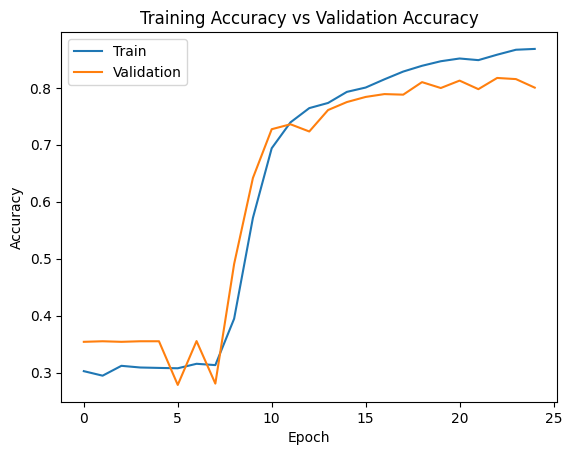

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Loss Plot for Training and Validation Set.

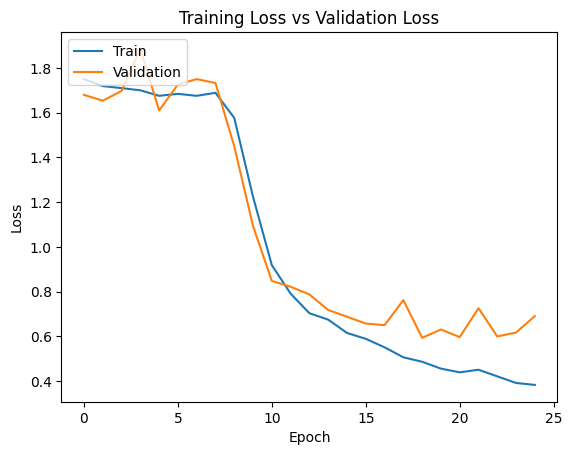

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Testing the Model.

In [29]:
def get_text(text):
    tokenizer3 = Tokenizer()
    tokenizer3.fit_on_texts(text)
    word_index3 = tokenizer3.word_index
    stemmer = PorterStemmer()
    stemmed_wordss = [stemmer.stem(word) for word in word_index3.keys()]

    tokens_list= tokenizer2.texts_to_sequences([stemmed_wordss])[0]

    for i in range(len(tokens_list)):
        for j in range(length_of_longest_sentence-len(tokens_list)):
            tokens_list.append(0)
    return tokens_list

In [30]:
 for _ in range(5):
    random_number = random.randint(0, 1000)
    num_to_predicte = random_number
    sentence=test_data['text'][num_to_predicte]
    test = get_text([test_data['text'][num_to_predicte]])

    test = np.array(test)
    test = test.reshape(1, len(test))

    # Make predictions
    predictions = model.predict(test)

    predicted_class = np.argmax(predictions)
    print()
    print('Random sentence = ', sentence)
    print("Predicted Class:", predicted_class,labels_dict.get(predicted_class))
    print("Actual Class:", test_data['label'][num_to_predicte])
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step

Random sentence =  i have tried to see what it would be like if i liked one of my girl friends but it has never really worked and i can only ever feel an emotional connection to them because they are my friends
Predicted Class: 0 sadness
Actual Class: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Random sentence =  i had been talking to coach claudia barcomb and coach ali boe for a long time and they both made me feel very welcomed at union
Predicted Class: 1 joy
Actual Class: 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Random sentence =  i don t know how i feel about my submissive learning how to use a firearm
Predicted Class: 0 sadness
Actual Class: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Random sentence =  i was so focused on my heavy breathing my even strides the drops of sweat on my forehead that i forgot to feel socially awkward
Predicted Class: 1 joy
Actual Class: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Random sentence =  i bought this dorae

Confusion Matrix

In [31]:
new_test_data=preprocess_data(test_data)

test_X = [row[0] for row in new_train_data]
test_y = [row[1] for row in new_train_data]

for i in range(len(test_X)):
    for j in range(length_of_longest_sentence-len(test_X[i])):
        test_X[i].append(0)

test_X = np.array(test_X)
test_y = np.array(test_y)

test_y_one_hot = to_categorical(test_y, num_classes=16000)

In [34]:
y_pred = model.predict(test_X)
y_pred_classes = np.argmax(y_pred, axis=1)

500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step


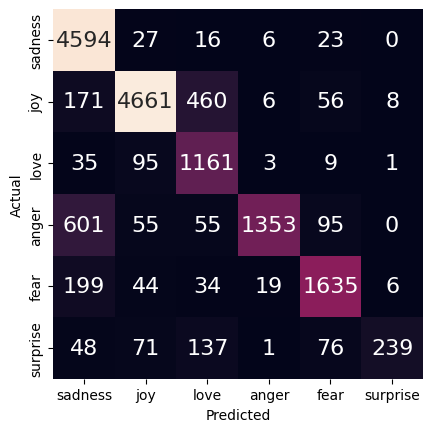

In [35]:
y_true_labels = np.argmax(test_y_one_hot, axis=1)

labels=['sadness','joy','love','anger','fear','surprise']
#labels = list(set(labels).intersection(set(np.unique(y_true_labels)).union(set(np.unique(y_pred_classes)))))

cm = confusion_matrix(y_true_labels, y_pred_classes)
df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={'size': 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 6)
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.invert_yaxis()
plt.show()

# **Testing the Model on User-Input Sentence.**

In [38]:
def predict_emotion(sentence):
    # Preprocess the user-entered sentence
    tokenized_sentence = get_text([sentence])

    # Pad the tokenized sentence to match the input length used during training
    padded_sentence = np.pad(tokenized_sentence, (0, length_of_longest_sentence - len(tokenized_sentence)), 'constant')

    # Reshape the padded sentence to fit the model input shape
    padded_sentence = padded_sentence.reshape(1, len(padded_sentence))

    # Make predictions
    predictions = model.predict(padded_sentence)

    # Get the predicted class
    predicted_class = np.argmax(predictions)

    # Map the predicted class to the corresponding emotion label
    predicted_emotion = labels_dict.get(predicted_class)

    return predicted_emotion

# Example usage of the predict_emotion function
user_sentence = input("Enter a sentence to predict emotion: ")
predicted_emotion = predict_emotion(user_sentence)
print("Predicted Emotion:", predicted_emotion)

Enter a sentence to predict emotion: I am content
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Emotion: joy
